# Connectivity estimation: directed versus undirected

The aim of this toy model is to illustrate the difference between estimating undirected connectivity with partial correlation (based on the zero-lag covariance matrix Q0) and directed connectivity based on time-shifted covariances of the observed activity (Q1 in addition to Q0). It provides the basic concepts to understand the paper on connectivity estimation based on the more elaborate gradient descent (Gilson et al., PLoS Comput Biol 2016).

The script generates activity for a network with linear feedback in continuous time (multivariate Ornstein-Uhlenbeck) and subsampled the activity. From the observed subsampled activity we calculating the covariance matrices Q0 and Q1. These observables are the basis for the Pearson correlations (K), partial correlation (PC) and the multivariate autoregressive (MAR) estimates. 

Non-parametric significance testing is performed using the shuffling of the observed time series for the PC and MAR estimate to identify the connections in the original connectivity C. There, only weight estimates that significantly exceeds the null distribution (with a threshold corresponding to a p-value) are considered to be existing connections.

Goal:
- check influence of network parameters (size N, density p_C), simulation duration (T) and subsampling on connectivity estimates;
- evaluate sensitivity of statistical testing when varying the number of surrogates (n_shuf) and desired p-value (pval)

Refs:
- Gilson M, Moreno-Bote R, Ponce-Alvarez A, Ritter P, Deco G (2016) Estimation of directed Effective Connectivity from fMRI Functional Connectivity Hints at Asymmetries of Cortical Connectome. PLoS Comput Biol 12: e1004762; doi.org/10.1371/journal.pcbi.1004762
- en.wikipedia.org/wiki/Partial_correlation
- en.wikipedia.org/wiki/Autoregressive_model
- en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process


## Simulation of network activity

The multivariate Ornstein-Uhlenbeck process is simulated in discrete time, but with a small time step. The activity is then subsampled with a sample every second here.

The code is initially set with N=4 nodes and a specific connectivity.

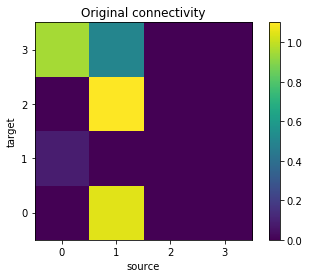

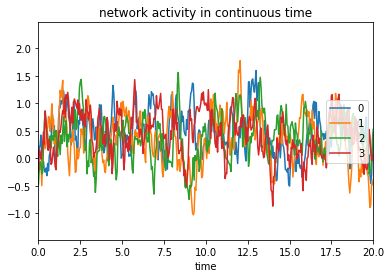

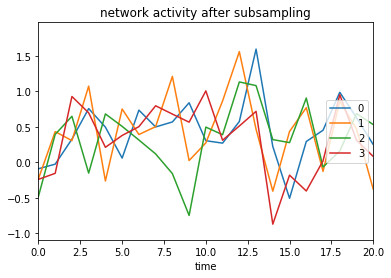

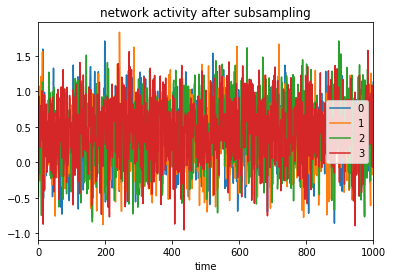

In [146]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pp

save_figs = False

# network and simulation parameters
N = 4 # number of nodes in network

tau_x = 1. # leakage time constant (common to all nodes, in second)
p_C = 0.25 # theoretical density for connectivity
min_C = 0. # minimal weight (relative)

mask_diag = np.eye(N,dtype=np.bool) # mask for diagonal elements

T0 = 100. # initialization time for network dynamics
T = 1000. # simulation duration

dt = 0.05 # temporal resolution for simulation (in second)
n_sampl = int(1./dt) # sampling rate to get 1 point every second

# slower sampling rate (for plot only)
n_sampl2 = n_sampl * 10 # 1 point every 10 s
T2 = T * n_sampl / n_sampl2


# function to simulate network activity
def sim_net_act(T_sim,C_sim,I_sim,Sigma_sim,subsampling=True):
    nT = int(T_sim/dt) # simulation timesteps
    nT0 = int(T0/dt) # simulation timesteps to ignore (due to initial condition)
    # simulated Jacobian
    J_sim = -np.eye(N)/tau_x + C_sim
    # simulated input noise
    Sigma_mix = spl.sqrtm(Sigma_sim)
    # simulation of multivariate Ornstein-Uhlenbeck simulation
    ts_sim = np.zeros([nT,N]) # time series
    v_noise = np.random.normal(size=[nT0+nT,N],scale=(dt**0.5)) # input noise
    x = np.zeros([N]) # initial condition
    for iT in range(nT0+nT):
        x += dt*np.dot(J_sim,x) + I_sim + np.dot(Sigma_mix,v_noise[iT,:])
        if iT>=nT0:
            ts_sim[iT-nT0,:] = x
    # return simulated time series
    if subsampling:
        return ts_sim[::n_sampl,:]
    else:
        return ts_sim

    
# create true connectivity in original network
if True:
    if not N==4:
        raise ValueError('set N = 4 nodes')
    # special case for 4 nodes
    C = np.array([[0.00,1.05,0.00,0.00],\
                  [0.09,0.00,0.00,0.00],\
                  [0.00,1.10,0.00,0.00],\
                  [0.95,0.50,0.00,0.00]])
else:
    # randomly connected C
    good_C = False
    while not good_C:
        C = min_C + (1-min_C) * np.random.rand(N,N) # random connectivity
        C[np.random.rand(N,N)>p_C] = 0 # set theoretical density to p_C
        C[mask_diag] = 0 # eliminate self-connections
        C *= 0.8 / ((1+min_C)/2) / N / p_C # rescaling
        # check if feedback in C not too strong
        good_C = np.real(np.linalg.eigvals(C).max())<1

I = 0.05 # constant input
Sigma = np.eye(N) # input covariance

# generate the network activity
ts_X = sim_net_act(T,C,I,Sigma,False)


# plots
T_aff = 20

pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.xlabel('source')
pp.ylabel('target')
pp.colorbar()
if save_figs:
    pp.savefig('orig_C')

pp.figure()
pp.title('network activity in continuous time')
pp.plot(np.arange(0,T,dt),ts_X)
pp.axis(xmin=0,xmax=T_aff)
pp.xlabel('time')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ts_cont')

pp.figure()
pp.title('network activity after subsampling')
pp.plot(np.arange(0,T),ts_X[::n_sampl,:])
pp.axis(xmin=0,xmax=T_aff)
pp.xlabel('time')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ts_ds1')

pp.figure()
pp.title('network activity after subsampling')
pp.plot(np.arange(0,T),ts_X[::n_sampl,:])
pp.axis(xmin=0,xmax=T)
pp.xlabel('time')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ts_ds1_whole')

pp.show()


## Temporal structure measured by autocovariances

The autovariance quantifies the "memory depth" of the simulated time series, which is how a given sample influences the successive samples. Depending on the subsmpling (every second or every 10 seconds here), the successive observed samples are dependent or not. This is important to check to understand whether this "temporal information" can be used to retrieve the underlying connectivity.

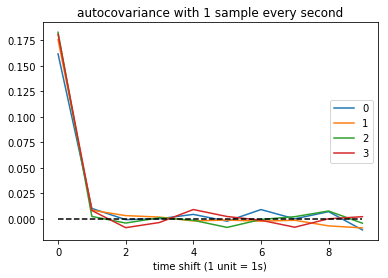

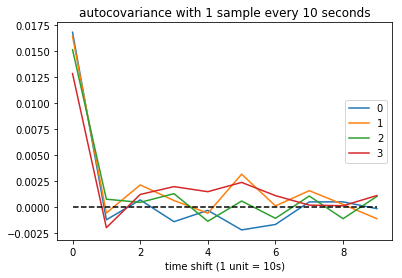

In [147]:
n_tau = 10 # number of time shifts

# demean subsampled time series
dm_ts_X = ts_X[::n_sampl,:]
dm_ts_X -= np.outer(np.ones([int(T)]),dm_ts_X.mean(0))

dm_ts_X2 = ts_X[::n_sampl2,:]
dm_ts_X2 -= np.outer(np.ones([int(T2)]),dm_ts_X.mean(0))

# autocovariance for discrete time series
ac = np.zeros([n_tau,N])
for i_tau in range(n_tau):
    ac[i_tau,:] = np.sum(dm_ts_X[0:int(T)-n_tau+1,:]*dm_ts_X[i_tau:int(T)-n_tau+1+i_tau,:],axis=0) / (T-n_tau)

# autocovariance for discrete time series
ac2 = np.zeros([n_tau,N])
for i_tau in range(n_tau):
    ac2[i_tau,:] = np.sum(dm_ts_X2[0:int(T2)-n_tau+1,:]*dm_ts_X2[i_tau:int(T2)-n_tau+1+i_tau,:],axis=0) / (T-n_tau)


# plots
pp.figure()
pp.title('autocovariance with 1 sample every second')
pp.plot(np.arange(0,n_tau),ac)
pp.plot([0,n_tau-1],[0,0],'--k')
pp.xlabel('time shift (1 unit = 1s)')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ac_ds1')

pp.figure()
pp.title('autocovariance with 1 sample every 10 seconds')
pp.plot(np.arange(0,n_tau),ac2)
pp.plot([0,n_tau-1],[0,0],'--k')
pp.xlabel('time shift (1 unit = 10s)')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ac_ds10')

pp.show()


## Observed covariances

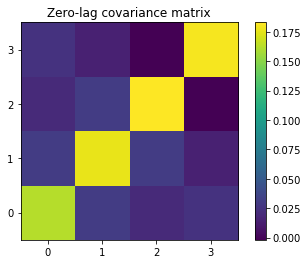

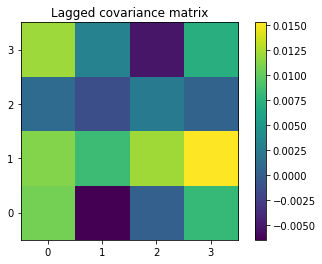

In [148]:
# observed time series
if True: # downsampling of 1 s
    ts_obs = dm_ts_X
    T_obs = int(T)
else: # downsampling of 10 s
    ts_obs = dm_ts_X2
    T_obs = int(T2)

# empirical covariances
Q0 = np.tensordot(ts_obs[0:T_obs-1,:],ts_obs[0:T_obs-1,:],axes=(0,0)) / (T_obs-2)
Q1 = np.tensordot(ts_obs[0:T_obs-1,:],ts_obs[1:T_obs,:],axes=(0,0)) / (T_obs-2)

# plots
pp.figure()
pp.title('Zero-lag covariance matrix')
pp.imshow(Q0,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('Q0')

pp.figure()
pp.title('Lagged covariance matrix')
pp.imshow(Q1,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('Q1')

pp.show()

## Model inversion: from observed activity (covariances) to connectivity estimate

From the observables, we calculate the connectivity estimates: Pearson correlation and partial correlation from Q0 only, while the MAR estimates uses both Q0 and Q1 (hence "temporal information").

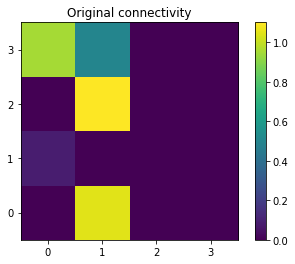

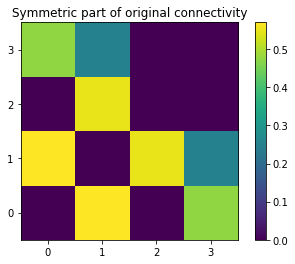

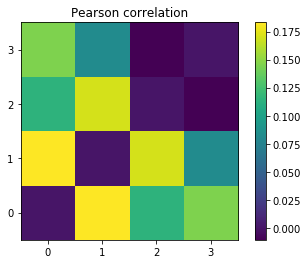

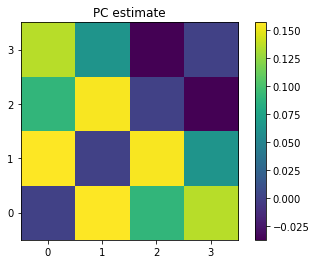

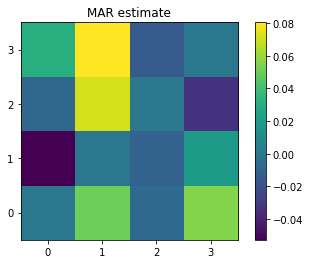

In [149]:
# Pearson correlations
K = np.array(Q0)
K /= np.sqrt(np.outer(K.diagonal(),K.diagonal()))
K[mask_diag] = 0

# partial correlation
PC = -np.linalg.pinv(Q0)
PC /= np.sqrt(np.outer(PC.diagonal(),PC.diagonal()))
PC[mask_diag] = 0

# MAR estimate
A_MAR = np.dot(np.linalg.pinv(Q0),Q1).T
A_MAR[mask_diag] = 0


# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('orig_C')

pp.figure()
pp.title('Symmetric part of original connectivity')
pp.imshow((C+C.T)*0.5,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('sym_C')

pp.figure()
pp.title('Pearson correlation')
pp.imshow(K,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('CORR')

pp.figure()
pp.title('PC estimate')
pp.imshow(PC,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('PC')

pp.figure()
pp.title('MAR estimate')
pp.imshow(A_MAR,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('A_MAR')

pp.show()

Note the different scales for the matrices above.

## Statistical testing

To check which estimated values are significantly different from 0, we compare these values with surrogates estimates by shuffling the time series.

In [150]:
# shuffling by random permutation of samples within each time series
n_shuf = 100 # number of surrogates
pval = 0.05 # desired p-value

PC_shuf = np.zeros([n_shuf,N,N])
A_shuf = np.zeros([n_shuf,N,N])
for i_shuf in range(n_shuf):
    ts_shuf = np.array(ts_obs)
    for i in range(N):
        ts_shuf[:,i] = ts_shuf[np.argsort(np.random.rand(T_obs)),i]
    # empirical covariances
    Q0_shuf = np.tensordot(ts_shuf[0:T_obs-1,:],ts_shuf[0:T_obs-1,:],axes=(0,0)) / (T_obs-2)
    Q1_shuf = np.tensordot(ts_shuf[0:T_obs-1,:],ts_shuf[1:T_obs,:],axes=(0,0)) / (T_obs-2)
    # PC estimate for shuffled time series
    PC_shuf[i_shuf,:,:] = -np.linalg.pinv(Q0_shuf)
    PC_shuf[i_shuf,:,:] /= np.sqrt(np.outer(PC_shuf[i_shuf,:,:].diagonal(),PC_shuf[i_shuf,:,:].diagonal()))
    PC_shuf[i_shuf,mask_diag] = 0
    # MAR estimate for shuffled time series
    A_shuf[i_shuf,:,:] = np.dot(np.linalg.pinv(Q0_shuf),Q1_shuf).T
    A_shuf[i_shuf,mask_diag] = 0

PC_shuf = np.sort(PC_shuf,axis=0)
A_shuf = np.sort(A_shuf,axis=0)
    
# retain only PC and MAR estimates that are stronger than 95%
PC_sig = np.zeros(PC.shape)
mask_PC_sig = PC>PC_shuf[-int(n_shuf*pval),:,:]
PC_sig[mask_PC_sig] = PC[mask_PC_sig]
mask_C_sym = (C+C.T)>0

A_sig = np.zeros(A_MAR.shape)
mask_A_sig = A_MAR>A_shuf[-int(n_shuf*pval),:,:]
A_sig[mask_A_sig] = A_MAR[mask_A_sig]
mask_C = C>0

Example of non-parametrix testing for 2 connections for the MAR estimate, from node j0 to node i0, and the reciprocal connections from i0 to j0.

Original connectivity
[[0.   1.05 0.   0.  ]
 [0.09 0.   0.   0.  ]
 [0.   1.1  0.   0.  ]
 [0.95 0.5  0.   0.  ]]


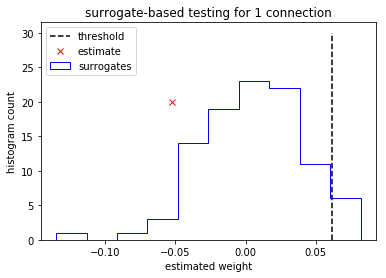

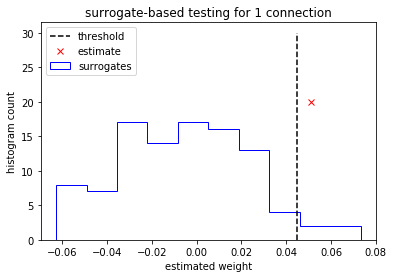

In [151]:
print('Original connectivity')
print(C)

i0 = 1 # target node for connection
j0 = 0 # source node for connection

pp.figure()
pp.title('surrogate-based testing for 1 connection')
pp.plot([A_shuf[-int(n_shuf*pval),i0,j0]]*2,[0,n_shuf*0.3],'--k')
pp.plot(A_MAR[i0,j0],n_shuf*0.2,'xr')
pp.hist(A_shuf[:,i0,j0],histtype='step',color='b')
pp.xlabel('estimated weight')
pp.ylabel('histogram count')
pp.legend(['threshold','estimate','surrogates'],loc='upper left')
if save_figs:
    pp.savefig('from_j0_to_i0_detect')

i0 = 0 # target node for connection
j0 = 1 # source node for connection

pp.figure()
pp.title('surrogate-based testing for 1 connection')
pp.plot([A_shuf[-int(n_shuf*pval),i0,j0]]*2,[0,n_shuf*0.3],'--k')
pp.plot(A_MAR[i0,j0],n_shuf*0.2,'xr')
pp.hist(A_shuf[:,i0,j0],histtype='step',color='b')
pp.xlabel('estimated weight')
pp.ylabel('histogram count')
pp.legend(['threshold','estimate','surrogates'],loc='upper left')
if save_figs:
    pp.savefig('from_i0_to_j0_detect')

pp.show()

statistical testing for partial correlation (PC)
True positive = hit: 4
False positive = false alarm: 1
False negative = miss: 0
True negative: 3


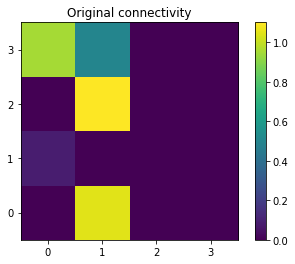

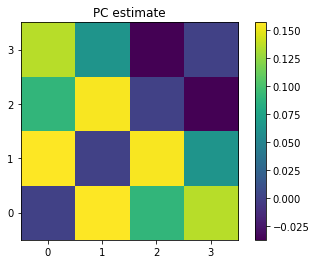

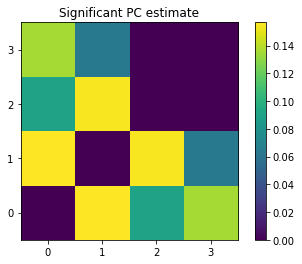

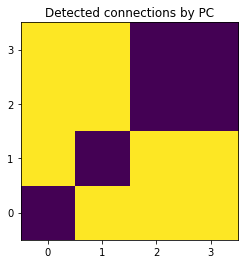

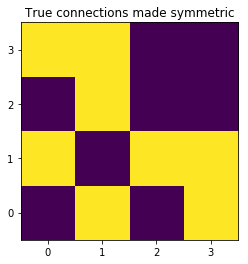

In [152]:
print('statistical testing for partial correlation (PC)')
print('True positive = hit:', int(np.logical_and(mask_PC_sig,mask_C_sym).sum()/2))
print('False positive = false alarm:', int(np.logical_and(mask_PC_sig,np.logical_not(mask_C_sym)).sum()/2))
print('False negative = miss:', int(np.logical_and(np.logical_not(mask_PC_sig),mask_C_sym).sum()/2))
print('True negative:', int(np.logical_and(np.logical_not(mask_PC_sig),np.logical_not(mask_C_sym)).sum()/2))

# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('PC estimate')
pp.imshow(PC,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('Significant PC estimate')
pp.imshow(PC_sig,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('sig_PC')

pp.figure()
pp.title('Detected connections by PC')
pp.imshow(mask_PC_sig.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('detect_PC')

pp.figure()
pp.title('True connections made symmetric')
pp.imshow(mask_C_sym.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('orig_conn_sym')

pp.show()

statistical testing for multivariate autoregressive model (MAR)
True positive = hit: 3
False positive = false alarm: 1
False negative = miss: 2
True negative: 10


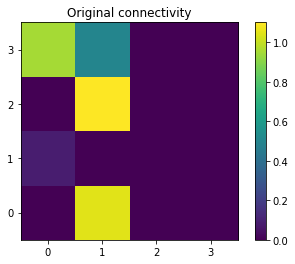

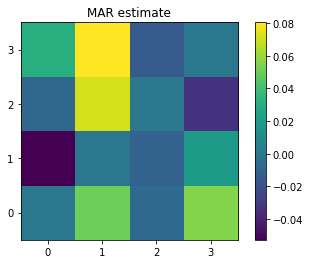

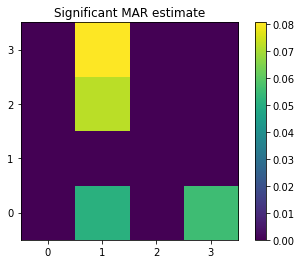

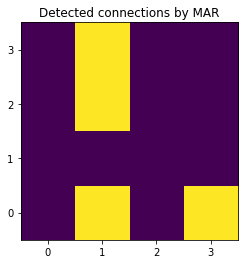

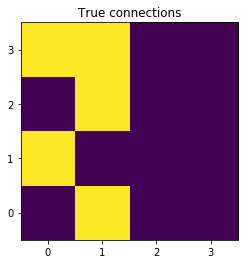

In [153]:
print('statistical testing for multivariate autoregressive model (MAR)')
print('True positive = hit:', np.logical_and(mask_A_sig,mask_C).sum())
print('False positive = false alarm:', np.logical_and(mask_A_sig,np.logical_not(mask_C)).sum())
print('False negative = miss:', np.logical_and(np.logical_not(mask_A_sig),mask_C).sum())
print('True negative:', np.logical_and(np.logical_not(mask_A_sig),np.logical_not(mask_C)).sum())

# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('MAR estimate')
pp.imshow(A_MAR,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('Significant MAR estimate')
pp.imshow(A_sig,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('sig_MAR')

pp.figure()
pp.title('Detected connections by MAR')
pp.imshow(mask_A_sig.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('detect_MAR')

pp.figure()
pp.title('True connections')
pp.imshow(mask_C.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('orig_conn')

pp.show()

# Exercises
- Is it possible to better detect the connectivity by observing more samples? Increase/decrease the duration T of generated signals.
- How robust is it for larger/denser networks? Change the number of nodes and use random connectivity (controlled by the density p_C and the minimum weight min_C) as original connectivity to generate the observed signals.
- Change the time constant tau_x to smaller values (e.g. 0.3) to generate signals that have flat autocorrelogram when subsampled every 1 second, to check the result from the MAR estimation. Is PC estimation still working?

## extras
- Change the input covariance matrix Sigma to explore the effect of spatially correlated inputs on the connectivity detection (see also the notebook comparison_estimate_directed_connectivity.ipynb).
- Use specific connectivty from GALib (e.g. scale-free network) as original connectivity.